In [1]:
import os,re
import cv2
import glob,h5py
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from annoy import AnnoyIndex
from PIL import Image, ImageDraw, ImageFont

from extractor import face_detect as Detect
from extractor import face_records as Records



load model: ./model/dbface.pth


In [32]:
def tomat(pil_img):
    """pil image to cv2 image"""
    img = cv2.cvtColor(np.asarray(pil_img),cv2.COLOR_RGB2BGR)
    return img

def topil(cv2_img):
    """ pil 转 cv2 bgr"""
    return Image.fromarray(cv2.cvtColor(cv2_img,cv2.COLOR_BGR2RGB))


def pil_with_label(pil_img, bbox = [72, 103, 208, 330], label = '胡歌', show_bbox=False):
    """ pil 字体显示文字 , 参考: https://blog.csdn.net/weixin_41735859/article/details/106599903
    """
    
    # pil_img = Image.open(img_path)
    # bbox = [72, 103, 208, 330] # 边框格式　bbox = [xl, yl, xr, yr]
    font = ImageFont.truetype(font="E:/1_software/font/simhei.ttf",  # 设置字体格式及大小
                              size=np.floor(1.5e-2 * np.shape(pil_img)[1] + 15).astype('int32'))
    
    draw = ImageDraw.Draw(pil_img)
    label_size = draw.textsize(label, font) # 获取label长宽
    text_origin = np.array([bbox[0], bbox[1] - label_size[1]])  # 设置label起点
    
    if show_bbox:
        # 绘制矩形框，加入label文本
        draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]],outline='red',width=2) ## bbox
    draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill='red') ### label区域
    draw.text(text_origin, str(label), fill=(255, 255, 255), font=font)  ### label文字
        
    del draw
    
    return pil_img



def load_feature_db(dbFile):
    h5f = h5py.File(dbFile, 'r')
    label_id = h5f['dataset_1'][:]
    label_id = [x.decode() for x in label_id]
    bbox = h5f['dataset_2'][:]
    img_vector = h5f['dataset_3'][:]
    h5f.close()

    bbox = [x.tolist() for x in bbox]
    img_vector = [x for x in img_vector]

    df = pd.DataFrame({'img_name': label_id,
                       'xyxy':bbox,
                       "img_vector": img_vector,
                       })

    # df = None
    return df


def build_index(db_file, indexFile):
    ntree = 30
    df = load_feature_db(db_file)
    f = len(df['img_vector'][0])  ### 向量长度 512
    t = AnnoyIndex(f, metric='euclidean')
    for i, vector in enumerate(df['img_vector']):
        t.add_item(i, vector)
    _ = t.build(ntree)
    t.save(indexFile)

In [3]:
query_id = "query"
query_src = cv2.imread("./images/3.jpg")
query_data = Records(query_id, query_src)

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [4]:
cn2en = {
            '其他': "others",
            '元恒结衣': "yhjy",
            '周冬雨': "zdy",
            '易阳天玺': "yytx",
            '普京':"pj",
            '杨幂':"ym",
            '特朗普':"tlp",
            '王俊凯':"wjk",
            '王源':"wy",
            '胡歌':"hg"
        }

en2cn = dict([v,k] for k,v in cn2en.items())


DF, INDEXER = None, None
dbPath = "./result/faces.h5"
indexPath = "./result/faces.ann"
if DF is None:
	DF = load_feature_db(dbPath)
if INDEXER is None:
	INDEXER = AnnoyIndex(512, metric='euclidean')
	INDEXER.load(indexPath)

In [72]:
def similar_map(query_emb, score_cutoff=0.6, num_threshold=10):
    def similar_score(a):
        def try_divide(x, y, val=0.0):
            if y != 0.0:
                val = float(x) / y
            return val
        
        v1, v2 = a[0], a[1]
        X = float(np.sum(v1 * v2))
        Y = np.linalg.norm(v1) * np.linalg.norm(v2)
        return try_divide(X, Y)
    
    similar_index = INDEXER.get_nns_by_vector(query_emb, int(num_threshold*1.5))
    result = DF.iloc[similar_index]
    xyxy = result.xyxy.tolist()
    names = result.img_name.tolist()

    data = [(name, box, score) for name, box, score in \
            zip(names, xyxy, list(map(similar_score, \
                            	[(query_emb, x) for x in result.img_vector]))) if score > score_cutoff]
    
    return data[:num_threshold]


def show_similar_face(data):
	
	def plot_box(cv2_bgr, box, label_text):
		""" 结果展示 """
		pil_img = Image.fromarray(cv2.cvtColor(cv2_bgr, cv2.COLOR_BGR2RGB))
		draw = ImageDraw.Draw(pil_img)
		font = ImageFont.truetype("E:/1_software/font/simhei.ttf",\
			size=np.floor(1.5e-2 * np.shape(cv2_bgr)[1] + 15).astype('int32'))
		label_size = draw.textsize(label_text, font)
		
		text_origin = np.array([box[0] - 2, box[1] - 5 - label_size[1]])  ### 文字起点
		draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill='red')
		draw.rectangle([box[0], box[1], box[2], box[3]], outline='red', width=4)
		draw.text(text_origin, label_text, fill=(255, 255, 255), font=font)

		return pil_img

	def pad(image, min_height, min_width):
        
		h, w, _ = image.shape
		""" 图片边填充 """
		if h < min_height:
			h_pad_top = int((min_height - h) / 2.0)
			h_pad_bottom = min_height - h - h_pad_top
		else:
			h_pad_top = 0
			h_pad_bottom = 0
		if w < min_width:
			w_pad_left = int((min_width - w) / 2.0)
			w_pad_right = min_width - w - w_pad_left
		else:
			w_pad_left = 0
			w_pad_right = 0

		return cv2.copyMakeBorder(image, h_pad_top,
								h_pad_bottom,
								w_pad_left, w_pad_right,
								cv2.BORDER_CONSTANT,
								value=(255, 255, 255),
								)
    
	def show_objs(data):
		(W,H ) = data[1]
		
		print(data)
		if len(data[-1]) > 0:
			obj_data = data[-1][0] ## [('pj_7.jpg', [266, 182, 395, 348], 0.8574376107492014)]
			sim_name = obj_data[0]
			similar_imgPath = os.path.join(imgroot, sim_name)
			label_name = os.path.splitext(sim_name)[0].split("_")[0]
			p_name = en2cn.get(label_name, '未知')
			
			box, score = obj_data[1], obj_data[2]
			score = "%.2f" % score
			im = cv2.imread(similar_imgPath)
			label_on = f"{p_name} {score}"
			img = plot_box(im, box, label_on)
			cv2_img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
			h, w, _  = cv2_img.shape
			r = min(H, W) / min(h, w)
			ww, hh = int(r * w),int(r * h)
			cv2_img = pad(cv2.resize(cv2_img, (ww, hh), cv2.INTER_AREA), H, W)

			# pil_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
			# return  Image.fromarray(pil_img)

			return cv2_img

		else:
			cv2_img = np.zeros((H, W, 3), np.uint8)
			cv2_img.fill(210)
			# pil_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
			return cv2_img
   

		
		

	imgroot = "./data"
	return show_objs(data)


def face_similar(image_id, image, face_score_cutoff=0.4, iou_cutoff=0.5, 
                 area_cutoff=1000, max_num_faces=2, similar_cutoff=0.6, max_similar_face=1):
	"""
	相似人脸检测
	:param image_id:
	:param image:
	:param face_score_cutoff:
	:param iou_cutoff:
	:param area_cutoff:
	:param max_num_faces:
	:param max_similar_face:
	:return:
	"""
	data = []
	h,w = image.shape[:2]
	objs = Records(image_id, image, face_score_cutoff, iou_cutoff, area_cutoff, max_num_faces)
	for i, obj in enumerate(objs):
		image_id = obj[0]
		[w, h] = obj[1]
		box = obj[2]
		vec = obj[4]
		r = similar_map(vec, score_cutoff=similar_cutoff, num_threshold=max_similar_face)
		data.append([image_id, [w, h], i, box, r, ] )
	
	del image,image_id, objs
	return data


查询结果：
['query', [370, 264], 0, 0, []]
(264, 370, 3) (264, 370, 3)


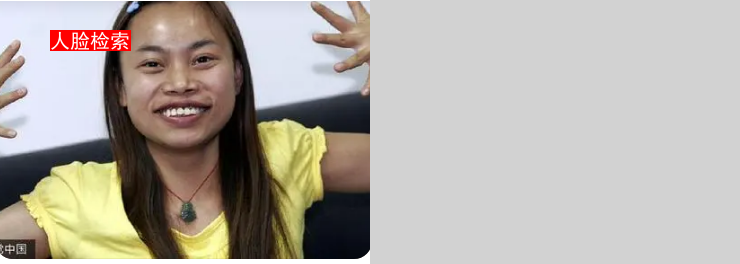

In [73]:
query_id = "query"
query_src = cv2.imread("./images/1.png")
query_src = cv2.imread("./images/2.jpg")
query_src = cv2.imread("./images/3.png")
query_src = cv2.imread("./images/4.png")
query_src = cv2.imread("./images/6.png")
query_src = cv2.imread("./images/8.png")
query_src = cv2.imread("./images/9.png")
data = face_similar(query_id, query_src, similar_cutoff=0.7)[0]
print("查询结果：")
simi_img = show_similar_face(data)
query_img = tomat(pil_with_label(topil(query_src), [50, 50, 80, 150], label="人脸检索"))

print(query_img.shape, simi_img.shape)
topil(np.hstack((query_img, simi_img)))

